In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import joblib
from datetime import datetime, timedelta
import warnings

## Data Collection, Preprocessing and EDA

In [2]:
#we are taking the dat for 4 months (one form each quarter of the year 2024). So we want data drom jan, ap, jul,ocr
df_jan = pd.read_parquet('data/yellow_tripdata_2024-01.parquet')
df_apr = pd.read_parquet('data/yellow_tripdata_2024-04.parquet')
df_jul = pd.read_parquet('data/yellow_tripdata_2024-07.parquet')
df_oct = pd.read_parquet('data/yellow_tripdata_2024-10.parquet')
#now, i am combining the data from the 4 months to one dataframe
df_all = pd.concat([df_jan, df_apr, df_jul, df_oct], ignore_index=True)
df_all.to_csv('data/yellow_tripdata_2024.csv', index=False)


In [3]:
df_all.columns


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [4]:
dfall=df_all.dropna(subset=['PULocationID'])
df_all['pickup_hour'] = df_all['tpep_pickup_datetime'].dt.floor('h')

In [5]:
#now, i am creating a seperate column "month". this will make comparision easier
df_all['month'] = df_all['tpep_pickup_datetime'].dt.to_period('M')


In [6]:
df_all.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'pickup_hour',
       'month'],
      dtype='object')

In [7]:
df_all.head

<bound method NDFrame.head of           VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                2  2024-01-01 00:57:55   2024-01-01 01:17:43   
1                1  2024-01-01 00:03:00   2024-01-01 00:09:36   
2                1  2024-01-01 00:17:06   2024-01-01 00:35:01   
3                1  2024-01-01 00:36:38   2024-01-01 00:44:56   
4                1  2024-01-01 00:46:51   2024-01-01 00:52:57   
...            ...                  ...                   ...   
13389582         2  2024-10-31 23:49:01   2024-11-01 00:04:31   
13389583         2  2024-10-31 23:35:15   2024-10-31 23:52:50   
13389584         2  2024-10-31 23:30:43   2024-11-01 00:08:12   
13389585         2  2024-10-31 23:00:00   2024-10-31 23:06:00   
13389586         2  2024-10-31 23:18:00   2024-10-31 23:51:00   

          passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                     1.0           1.72         1.0                  N   
1                     1.0           1.8

In [8]:
print(df_all['tpep_pickup_datetime'].min())
print(df_all['tpep_pickup_datetime'].max())

2002-12-31 22:10:04
2024-11-14 18:30:00


In [9]:
""" 
there shouldn't be dates for year except 2024. 
Also, a months except Jan, Ap, Jun and oct are also present. 
Data need cleaning is needed
"""
df_all=df_all[df_all['month'].dt.year==2024]
valid_months=[1,4,7,10]
df_all=df_all[df_all['month'].dt.month.isin(valid_months)]

In [10]:
print(df_all['tpep_pickup_datetime'].min())
print(df_all['tpep_pickup_datetime'].max())

2024-01-01 00:00:00
2024-10-31 23:59:59


<Axes: title={'center': 'Total Trips per Month'}, xlabel='Month', ylabel='Number of Trips'>

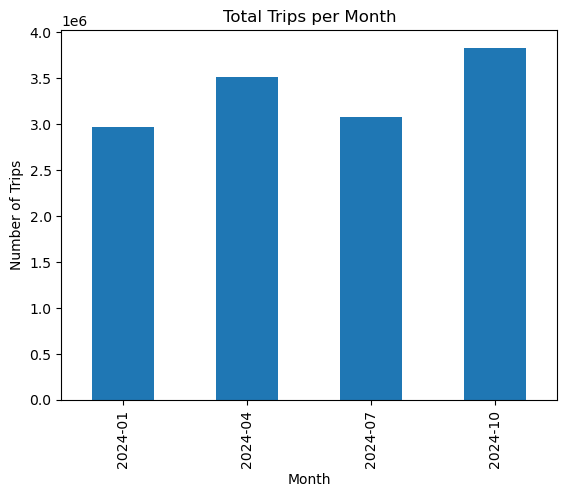

In [11]:
# Calculating the total trips per month. teying to figure out the distribution
month_count=df_all.groupby('month').size()
month_count.plot(kind='bar', title='Total Trips per Month', xlabel='Month', ylabel='Number of Trips')

<Axes: title={'center': 'Average Trip Duration per Month'}, xlabel='Month', ylabel='Average Duration (minutes)'>

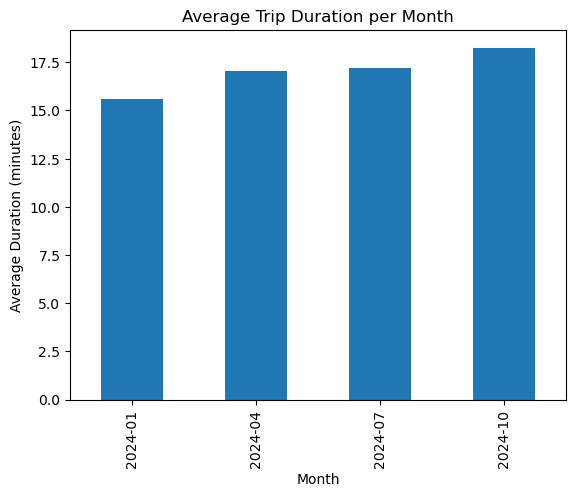

In [12]:
df_all['trip_duration']=(df_all['tpep_dropoff_datetime'] - df_all['tpep_pickup_datetime']).dt.total_seconds() / 60
monthly_dur= df_all.groupby('month')['trip_duration'].mean()
monthly_dur.plot(kind='bar', title='Average Trip Duration per Month', xlabel='Month', ylabel='Average Duration (minutes)')

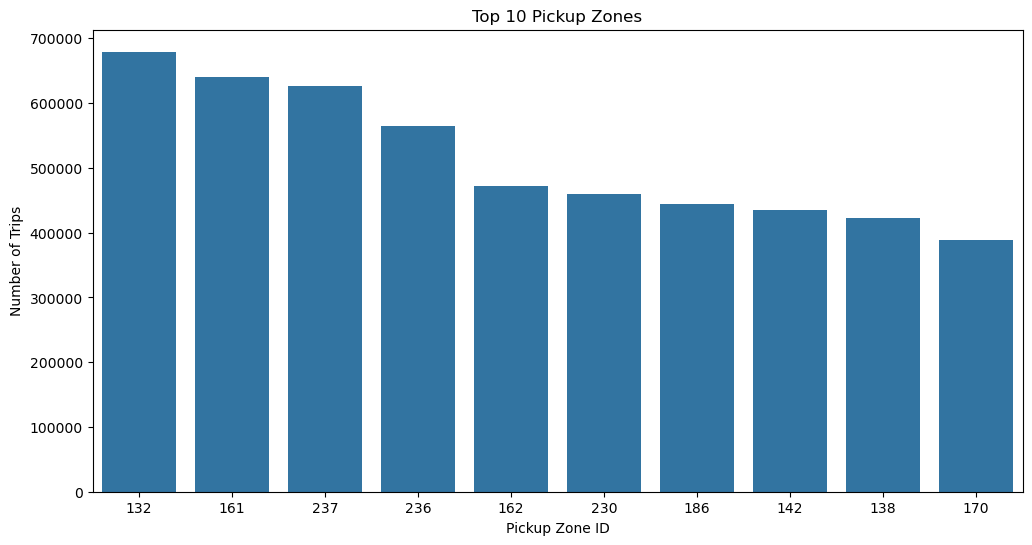

In [13]:
#identifying the top 10 pickup zones
top_zones=df_all['PULocationID'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_zones.index.astype(str), y=top_zones.values)
plt.title('Top 10 Pickup Zones')
plt.xlabel('Pickup Zone ID')
plt.ylabel('Number of Trips')
plt.show()

/var/folders/2k/312tx86x7sq7m7sbv0vvn4t40000gn/T/ipykernel_1299/3347610853.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pickup_hour'] = df_filtered['tpep_pickup_datetime'].dt.hour


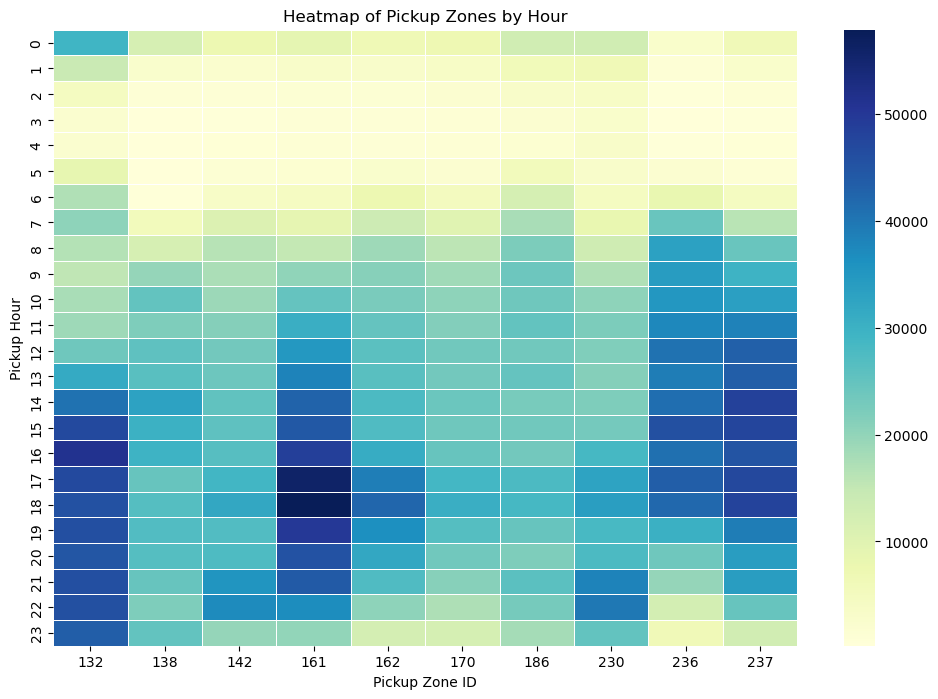

In [15]:
#heatmap of hourly pickup volume for the top 10 zones
top_zones = df_all['PULocationID'].value_counts().head(10).index.tolist()
df_filtered = df_all[df_all['PULocationID'].isin(top_zones)]
df_filtered['pickup_hour'] = df_filtered['tpep_pickup_datetime'].dt.hour
heat_data = df_filtered.groupby(['pickup_hour', 'PULocationID']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heat_data, cmap='YlGnBu', annot=False, linewidths=0.5)
plt.title('Heatmap of Pickup Zones by Hour')
plt.ylabel('Pickup Hour')
plt.xlabel('Pickup Zone ID')
plt.show()

## Analytics/ Prediction:

In [16]:


df_grouped = df_all.groupby(['pickup_hour', 'PULocationID']).size().reset_index(name='pickup_count')
df_pivot = df_grouped.pivot(index='pickup_hour', columns='PULocationID', values='pickup_count').fillna(0)
df_pivot.index = pd.to_datetime(df_pivot.index)

#scaling the data (using the mimmax scaler)
scaler = MinMaxScaler()
df_scaled_values = scaler.fit_transform(df_pivot) 
df_scaled_df = pd.DataFrame(df_scaled_values, columns=df_pivot.columns, index=df_pivot.index)

# Save the scaler in a pickle filee
joblib.dump(scaler, "scaler.pkl")


sequence_length = 24 #using past 24 hrs to predict the next hr

def extract_temporal_features(timestamp):
    return np.array([
        timestamp.hour, # Hour of day (values range from : 0-23)
        timestamp.dayofweek, # Day of week (0-6)
        timestamp.day, # Day of month (1-31)
        timestamp.month,  # Month (1-12)
        #using cyclic hour encoding below, because time is cyclic in some senses
        # for ex: 0 & 23 are seen as far apart (even though its only 1 hr apart), and can confuse the model.
        np.sin(2 * np.pi * timestamp.hour / 24),
        np.cos(2 * np.pi * timestamp.hour / 24),
        np.sin(2 * np.pi * timestamp.dayofweek / 7),
        np.cos(2 * np.pi * timestamp.dayofweek / 7),
    ])
#creating sequences for lstm. preps the input features and lables
def create_global_sequences(df_scaled_df, sequence_length):
    X_seq, X_temp, X_zone, y = [], [], [], []
    zones = df_scaled_df.columns
    timestamps = df_scaled_df.index

    for i in range(sequence_length, len(timestamps)):
        for j, zone in enumerate(zones):
            seq = df_scaled_df[zone].iloc[i-sequence_length:i].values
            #demand val of current time for particular zon
            label = df_scaled_df[zone].iloc[i]
            #extracting temporal features from the timestamp
            temp_feat = extract_temporal_features(timestamps[i])

            X_seq.append(seq)
            X_temp.append(temp_feat)
            X_zone.append(j)
            y.append(label)

    return np.array(X_seq), np.array(X_temp), np.array(X_zone), np.array(y)

X_seq, X_temp, X_zone, y = create_global_sequences(df_scaled_df, sequence_length)


X_seq_train, X_seq_test, X_temp_train, X_temp_test, X_zone_train, X_zone_test, y_train, y_test = train_test_split(
    X_seq, X_temp, X_zone, y, test_size=0.2, random_state=42
)

# converting to tensors (cause we are using pytorch)
X_seq_train = torch.tensor(X_seq_train, dtype=torch.float32).unsqueeze(-1)
X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32).unsqueeze(-1)
X_temp_train = torch.tensor(X_temp_train, dtype=torch.float32)
X_temp_test = torch.tensor(X_temp_test, dtype=torch.float32)
X_zone_train = torch.tensor(X_zone_train, dtype=torch.float32).unsqueeze(1)
X_zone_test = torch.tensor(X_zone_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

#building the lstm model architecture
class GlobalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, temporal_size, zone_size):
        super(GlobalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2) #i added the dropout layer to avoid overfitting
        self.fc1 = nn.Linear(hidden_size + temporal_size + zone_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x_seq, x_temp, x_zone):
        _, (hidden, _) = self.lstm(x_seq)
        lstm_out = self.dropout(hidden[-1])

        combined = torch.cat([lstm_out, x_temp, x_zone], dim=1)
        x = self.relu(self.fc1(combined))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

#training the lstm model
model = GlobalLSTM(1, 50, 8, 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

X_seq_train = X_seq_train.to(device)
X_seq_test = X_seq_test.to(device)
X_temp_train = X_temp_train.to(device)
X_temp_test = X_temp_test.to(device)
X_zone_train = X_zone_train.to(device)
X_zone_test = X_zone_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

#training the model for 30 epochs
for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    pred = model(X_seq_train, X_temp_train, X_zone_train).squeeze()
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0: #prints the loss every 5 epochs
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Calculating the residulas
model.eval()
with torch.no_grad():
    y_pred_lstm = model(X_seq_test, X_temp_test, X_zone_test).squeeze().cpu()
residuals = y_test.cpu() - y_pred_lstm

X_seq_flat = X_seq_test.cpu().reshape(X_seq_test.shape[0], -1).numpy()
X_temp_np = X_temp_test.cpu().numpy()
X_zone_np = X_zone_test.cpu().numpy()
X_xgb = np.hstack([X_seq_flat, X_temp_np, X_zone_np])
#training the xgboost model on the residuals
xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X_xgb, residuals.numpy())

# here, i am saving all the models to pickl files. helps in resuing the models
torch.save(model.state_dict(), "global_lstm.pt")
joblib.dump(xgb_model, "global_xgb.pkl")
df_scaled_df.to_pickle("scaled_demand_df.pkl")
print("training complete + models saved")

Epoch 0, Loss: 0.3203
Epoch 5, Loss: 0.0725
Epoch 10, Loss: 0.0476
Epoch 15, Loss: 0.0326
Epoch 20, Loss: 0.0278
Epoch 25, Loss: 0.0245
training complete + models saved


In [20]:

import warnings
warnings.filterwarnings('ignore')

class GlobalLSTM(nn.Module):
    #defining the lstm model architecture
    def __init__(self, input_size, hidden_size, temporal_size, zone_size):
        super(GlobalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size + temporal_size + zone_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x_seq, x_temp, x_zone):
        _, (hidden, _) = self.lstm(x_seq)
        lstm_out = self.dropout(hidden[-1])
        combined = torch.cat([lstm_out, x_temp, x_zone], dim=1)
        x = self.relu(self.fc1(combined))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

class TaxiDemandPredictor:
    def __init__(self, lstm_model_path="global_lstm.pt", xgb_model_path="global_xgb.pkl", scaler_path="scaler.pkl"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.sequence_length = 24

        self.lstm_model = GlobalLSTM(1, 50, 8, 1)
        self.lstm_model.load_state_dict(torch.load(lstm_model_path, map_location=self.device))
        self.lstm_model.to(self.device)
        self.lstm_model.eval()

        self.xgb_model = joblib.load(xgb_model_path)
        self.scaler = joblib.load(scaler_path)

        print("model loaded successfully")

    def extract_temporal_features(self, timestamp):
        #extracts the tempotal fetauress
        return np.array([
            timestamp.hour,
            timestamp.weekday(),
            timestamp.day,
            timestamp.month,
            np.sin(2 * np.pi * timestamp.hour / 24),
            np.cos(2 * np.pi * timestamp.hour / 24),
            np.sin(2 * np.pi * timestamp.weekday() / 7),
            np.cos(2 * np.pi * timestamp.weekday() / 7),
        ])

    def generate_synthetic_sequence(self, zone_id, target_time):
        """ 
        Creates a synthetic dmeand hostory for a specific zone
        """
        sequence = []
        for i in range(self.sequence_length):
            time_point = target_time - timedelta(hours=self.sequence_length - i)
            hour = time_point.hour

            if 6 <= hour <= 9:
                base_demand = 0.7 + np.random.normal(0, 0.1)
            elif 17 <= hour <= 20:
                base_demand = 0.8 + np.random.normal(0, 0.1)
            elif 22 <= hour or hour <= 3:
                base_demand = 0.4 + np.random.normal(0, 0.15)
            else:
                base_demand = 0.5 + np.random.normal(0, 0.1)
            #weekend
            if time_point.weekday() >= 5:
                if 22 <= hour or hour <= 3:
                    base_demand *= 1.3
                else:
                    base_demand *= 0.8
            #zone specific modeifier
            zone_factor = 0.5 + (hash(str(zone_id)) % 100) / 200
            base_demand *= zone_factor
            base_demand = max(0, min(1, base_demand))
            sequence.append(base_demand)

        return np.array(sequence)

    def predict_single(self, zone_id, datetime_str):
        target_time = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
        #genreating synthetic demand sequence
        sequence = self.generate_synthetic_sequence(zone_id, target_time)
        temporal_features = self.extract_temporal_features(target_time)
        #prepping the tensors for lstm
        X_seq = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(self.device)
        X_temp = torch.tensor(temporal_features, dtype=torch.float32).unsqueeze(0).to(self.device)
        X_zone = torch.tensor([[float(zone_id)]], dtype=torch.float32).to(self.device)

        with torch.no_grad():
            lstm_pred = self.lstm_model(X_seq, X_temp, X_zone).squeeze().cpu().numpy()
        #here i am prepping the fetures for xgboost
        X_seq_flat = sequence.reshape(1, -1)
        X_temp_np = temporal_features.reshape(1, -1)
        X_zone_np = np.array([[zone_id]])
        X_xgb = np.hstack([X_seq_flat, X_temp_np, X_zone_np])
        residual_pred = self.xgb_model.predict(X_xgb)[0] #predict residual using xgboost

        final_pred_scaled = lstm_pred + residual_pred

        dummy_array = np.zeros((1, self.scaler.n_features_in_))
        dummy_array[0, min(zone_id, self.scaler.n_features_in_ - 1)] = final_pred_scaled
        denormalized = self.scaler.inverse_transform(dummy_array)
        final_pred = denormalized[0, min(zone_id, self.scaler.n_features_in_ - 1)]

        return max(0, final_pred)

    def predict_with_intervals(self, zone_id, datetime_str):
        #predicting arounf the time itnervals (15, 30 and 60 min before + after specified time)
        base_time = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
        intervals = [-60, -30, -15, 0, 15, 30, 60]
        results = {}

        for interval in intervals:
            target_time = base_time + timedelta(minutes=interval)
            target_str = target_time.strftime("%Y-%m-%d %H:%M:%S")

            try:
                prediction = self.predict_single(zone_id, target_str)
                results[f"{interval:+d}min"] = {
                    "datetime": target_str,
                    "predicted_demand": round(prediction, 2)
                }
            except Exception as e:
                results[f"{interval:+d}min"] = {
                    "datetime": target_str,
                    "predicted_demand": f"Error: {str(e)}"
                }

        return results

    def print_predictions(self, zone_id, datetime_str):
        print(f"\n Taxi Demand Predictions for Zone ID: {zone_id}")
        print(f"Base Time: {datetime_str}")
        print("=" * 60)
        results = self.predict_with_intervals(zone_id, datetime_str)

        for interval, data in results.items():
            
            print(f" {interval:>6}: {data['datetime']} | Demand: {data['predicted_demand']}")
        
        return results

# Helper function
def predict_demand(zone_id, datetime_str):
    try:
        predictor = TaxiDemandPredictor()
        return predictor.print_predictions(zone_id, datetime_str)
    except Exception as e:
        print(f"Error: {e}")
        return None


In [21]:
predict_demand(161, "2026-09-01 12:20:00")

model loaded successfully

 Taxi Demand Predictions for Zone ID: 161
Base Time: 2026-09-01 12:20:00
 -60min: 2026-09-01 11:20:00 | Demand: 2.36
 -30min: 2026-09-01 11:50:00 | Demand: 2.17
 -15min: 2026-09-01 12:05:00 | Demand: 2.82
  +0min: 2026-09-01 12:20:00 | Demand: 2.59
 +15min: 2026-09-01 12:35:00 | Demand: 2.5
 +30min: 2026-09-01 12:50:00 | Demand: 2.75
 +60min: 2026-09-01 13:20:00 | Demand: 2.34


{'-60min': {'datetime': '2026-09-01 11:20:00', 'predicted_demand': 2.36},
 '-30min': {'datetime': '2026-09-01 11:50:00', 'predicted_demand': 2.17},
 '-15min': {'datetime': '2026-09-01 12:05:00', 'predicted_demand': 2.82},
 '+0min': {'datetime': '2026-09-01 12:20:00', 'predicted_demand': 2.59},
 '+15min': {'datetime': '2026-09-01 12:35:00', 'predicted_demand': 2.5},
 '+30min': {'datetime': '2026-09-01 12:50:00', 'predicted_demand': 2.75},
 '+60min': {'datetime': '2026-09-01 13:20:00', 'predicted_demand': 2.34}}

## Evaluating (RSME, MAE and R2)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Predict using the LSTM + XGBoost hybrid
model.eval()
with torch.no_grad():
    lstm_preds = model(X_seq_test, X_temp_test, X_zone_test).squeeze().cpu().numpy()

# Prepare XGBoost inputs
X_seq_flat_test = X_seq_test.cpu().reshape(X_seq_test.shape[0], -1).numpy()
X_temp_np_test = X_temp_test.cpu().numpy()
X_zone_np_test = X_zone_test.cpu().numpy()
X_xgb_test = np.hstack([X_seq_flat_test, X_temp_np_test, X_zone_np_test])

# Predict residuals and combine with LSTM output
xgb_residuals = xgb_model.predict(X_xgb_test)
hybrid_preds = lstm_preds + xgb_residuals


if isinstance(y_test, torch.Tensor):
    y_true = y_test.cpu().numpy()
else:
    y_true = y_test  

# computing metrics 
rmse = np.sqrt(mean_squared_error(y_true, hybrid_preds))
mae = mean_absolute_error(y_true, hybrid_preds)
r2 = r2_score(y_true, hybrid_preds)

print(" Evaluation Metrics:")
print(f" RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


 Evaluation Metrics:
 RMSE: 0.0830
MAE : 0.0508
R²  : 0.7199


In [ ]:

#now i want to compare it with metrics from the lstm model alone
model.eval()
with torch.no_grad():
    lstm_preds = model(X_seq_test, X_temp_test, X_zone_test).squeeze().cpu().numpy()
y_true = y_test.cpu().numpy()

# computing the merrics
rmse = np.sqrt(mean_squared_error(y_true, lstm_preds))
mae = mean_absolute_error(y_true, lstm_preds)
r2 = r2_score(y_true, lstm_preds)


print("Evaluating the LSTM model only")
print(f" RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


Evaluating the LSTM model only
 RMSE: 0.1634
MAE : 0.1322
R²  : -0.0868


In [35]:

y_true_np = y_test.cpu().numpy()

zone_ids = X_zone_test.squeeze().cpu().numpy().astype(int)
time_features = X_temp_test.cpu().numpy()  
hours = time_features[:, 0].astype(int)
weekdays = time_features[:, 1].astype(int)

#creating a dataframe for ecaluation
df_eval = pd.DataFrame({
    'zone_id': zone_ids,
    'hour': hours,
    'weekday': weekdays,
    'true': y_true_np,
    'pred': hybrid_preds
})

# Compute RMSE by zone
zone_rmse = df_eval.groupby('zone_id').apply(lambda x: np.sqrt(mean_squared_error(x['true'], x['pred'])))
print("\n Top 10 zones with highest RMSE:")
print(zone_rmse.sort_values(ascending=False).head(10))

# Compute RMSE by hour
hour_rmse = df_eval.groupby('hour').apply(lambda x: np.sqrt(mean_squared_error(x['true'], x['pred'])))
print("\nRMSE by hour (to find rush hour errors):")
print(hour_rmse)

# Computing RSME for weedend/weekday. this helps see if the model performs better if it's a week day or a weekend
df_eval['is_weekend'] = df_eval['weekday'] >= 5
weekend_rmse = df_eval.groupby('is_weekend').apply(lambda x: np.sqrt(mean_squared_error(x['true'], x['pred'])))
print("\nRMSE by weekday/weekend :")
print(weekend_rmse)



 Top 10 zones with highest RMSE:
zone_id
237    0.139947
19     0.135019
118    0.131857
77     0.131463
248    0.131252
255    0.131217
198    0.127520
85     0.127452
93     0.126791
105    0.126183
dtype: float64

RMSE by hour (to find rush hour errors):
hour
0     0.074789
1     0.049274
2     0.040782
3     0.040250
4     0.054733
5     0.075031
6     0.097302
7     0.113120
8     0.106067
9     0.100597
10    0.094972
11    0.092103
12    0.095930
13    0.094211
14    0.093137
15    0.090523
16    0.083463
17    0.083240
18    0.076699
19    0.071153
20    0.071064
21    0.073761
22    0.083397
23    0.081963
dtype: float64

RMSE by weekday/weekend :
is_weekend
False    0.083338
True     0.081953
dtype: float64


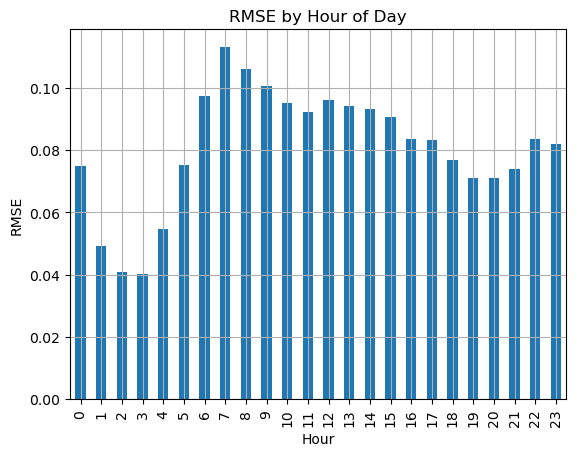

In [36]:
#plotting the rsme for by the hour of the day

hour_rmse.plot(kind='bar')
plt.title("RMSE by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()
